In [411]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [296]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','long_int','short_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)

# To prevent LinAlg errors:
df_variable_raw['exch_rate'].loc["United States"] += np.random.normal(0,0.01,df_variable_raw['exch_rate'].shape[1])
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'] / df_variable_raw['CPI'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])
variable_list = ['GDP', 'inf_rate','long_int','short_int','exch_rate']
ext_variable_list = ['Real gross domestic product','Inflation rate','Long-term interest rate','Short-term interest rate','Real exchange rate']

In [297]:
# Example of the data of GDP
df_variable['GDP']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,,,,,,,,,,,,,,,,,,,,,
Australia,7.111526,7.109974,7.109045,7.108639,7.108802,7.109724,7.111451,7.113886,7.117012,7.120009,...,7.245003,7.242691,7.240865,7.237977,7.234116,7.229641,7.224830,7.220180,7.215890,7.212375
Brazil,7.298547,7.265720,7.255515,7.248464,7.248838,7.252285,7.254880,7.258204,7.255993,7.247954,...,6.245628,6.238087,6.235718,6.230620,6.238351,6.242242,6.244860,6.238253,6.232938,6.225192
Canada,7.182050,7.181960,7.179124,7.179272,7.178639,7.181598,7.184533,7.187242,7.188597,7.188877,...,7.249739,7.246856,7.236032,7.232001,7.232621,7.237186,7.237162,7.230052,7.228093,7.232778
France,7.380348,7.374446,7.367507,7.366746,7.365897,7.368816,7.372472,7.375927,7.374124,7.372342,...,7.389731,7.387556,7.382731,7.376268,7.373598,7.368834,7.374215,7.363898,7.361342,7.363840
Germany,7.682714,7.688150,7.695440,7.699543,7.700288,7.699928,7.699483,7.701185,7.704330,7.707481,...,7.624106,7.616684,7.606889,7.607831,7.605180,7.603438,7.586272,7.577714,7.571316,7.566637
Italy,7.396040,7.389030,7.383779,7.379578,7.376119,7.374964,7.376462,7.375475,7.373617,7.371353,...,7.043788,7.048628,7.044076,7.034828,7.031480,7.023761,7.020841,6.986684,6.981243,6.978765
Japan,12.850322,12.864937,12.870368,12.868049,12.867329,12.870474,12.871490,12.873739,12.872666,12.874797,...,12.959260,12.960084,12.961055,12.962100,12.956011,12.949845,12.943860,12.937610,12.938058,12.942606
Korea,13.774596,13.780142,13.781106,13.780902,13.780954,13.786446,13.787371,13.788933,13.793843,13.800024,...,14.099692,14.094856,14.090692,14.086429,14.082658,14.084086,14.080734,14.076859,14.075656,14.070829
New Zealand,5.010273,5.009471,5.010367,5.012259,5.014867,5.017504,5.019902,5.021249,5.021431,5.020249,...,5.200104,5.201987,5.205242,5.206727,5.206079,5.203146,5.198064,5.190857,5.181424,5.169673


In [298]:
# Get all countries in a list
country_list = df_variable['GDP'].index.values

# Define an empty dataframe
df = {}

# Loop over all countries and put their variable data in dataframe df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [299]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,9.442539,9.449189,9.451437,9.452844,9.454810,9.457333,9.458181,9.459295,9.459754,9.460273,...,9.439093,9.433012,9.422873,9.411266,9.414238,9.417735,9.418474,9.416719,9.418875,9.421459
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.253143,-4.260530,-4.274974,-4.272891,-4.281850,-4.258729,-4.270995,-4.275728,-4.291334,-4.280814,...,-4.875569,-4.893332,-4.896224,-4.910883,-4.933040,-4.907769,-4.929956,-4.916521,-4.912732,-4.921561


# Trade matrix

In [300]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1994 until 2022)
year_list = df_trade_raw.columns

# Define an empty dataframe
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dataframe df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [301]:
# Example of the trade weights on the year 2000
df_trade_year[2000]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.009499,0.024256,0.015715,0.022248,0.031067,0.368421,0.139010,0.109102,0.021377,0.012284,0.063816,0.183204
Brazil,0.012822,0.000000,0.021274,0.065131,0.095000,0.080711,0.092992,0.021844,0.001296,0.011364,0.037926,0.056359,0.503281
Canada,0.003000,0.002689,0.000000,0.004871,0.007887,0.004335,0.022968,0.005707,0.000482,0.000620,0.001581,0.014831,0.931028
France,0.006890,0.014365,0.014387,0.000000,0.277243,0.155041,0.027482,0.013763,0.001199,0.006146,0.160982,0.169509,0.152993
Germany,0.011850,0.017602,0.015107,0.236602,0.000000,0.158056,0.046231,0.015814,0.001668,0.013074,0.093985,0.173398,0.216612
Italy,0.013134,0.016574,0.015812,0.224279,0.267343,0.000000,0.029327,0.012335,0.001646,0.006712,0.111315,0.121739,0.179782
Japan,0.034618,0.010164,0.030154,0.030228,0.080685,0.023379,0.000000,0.123875,0.005102,0.007577,0.013335,0.059860,0.581023
Korea,0.031966,0.021146,0.029763,0.021458,0.063209,0.023418,0.251006,0.000000,0.003509,0.006069,0.018803,0.065981,0.463673
New Zealand,0.302224,0.003885,0.022302,0.022475,0.034591,0.025347,0.205571,0.065756,0.000000,0.005530,0.008444,0.082456,0.221417
South Africa,0.042235,0.017777,0.019369,0.047268,0.167820,0.074288,0.119648,0.052628,0.002717,0.000000,0.043997,0.199527,0.212726


In [302]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[1993] + df_trade_year[1994] + df_trade_year[1995])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.008695,0.031125,0.020313,0.027501,0.029473,0.422486,0.132150,0.115496,0.012373,0.007620,0.067694,0.125073
Brazil,0.012786,0.000000,0.024467,0.046825,0.103713,0.080085,0.136933,0.034136,0.001838,0.011543,0.039634,0.063569,0.444472
Canada,0.004381,0.004788,0.000000,0.006822,0.012462,0.006200,0.048321,0.010508,0.000680,0.000768,0.001999,0.015696,0.887375
France,0.007999,0.007755,0.012718,0.000000,0.317674,0.173072,0.035865,0.012381,0.001229,0.006044,0.129186,0.174254,0.121825
Germany,0.015579,0.018173,0.013884,0.262833,0.000000,0.165993,0.058338,0.024076,0.002175,0.016558,0.073423,0.176180,0.172786
Italy,0.011154,0.017354,0.015598,0.230207,0.336073,0.000000,0.037012,0.015691,0.001984,0.007676,0.082110,0.112037,0.133103
Japan,0.040304,0.009912,0.029764,0.027565,0.092120,0.017409,0.000000,0.121341,0.007258,0.010393,0.010995,0.063685,0.569254
Korea,0.027392,0.018277,0.031319,0.023447,0.093984,0.016194,0.287797,0.000000,0.003286,0.007146,0.013616,0.042586,0.434957
New Zealand,0.313003,0.005407,0.025821,0.017027,0.037556,0.020387,0.237031,0.075653,0.000000,0.003830,0.006465,0.091912,0.165908
South Africa,0.029227,0.024074,0.012801,0.063221,0.153470,0.093988,0.105488,0.054068,0.002478,0.000000,0.046956,0.234887,0.179344


# VARX model

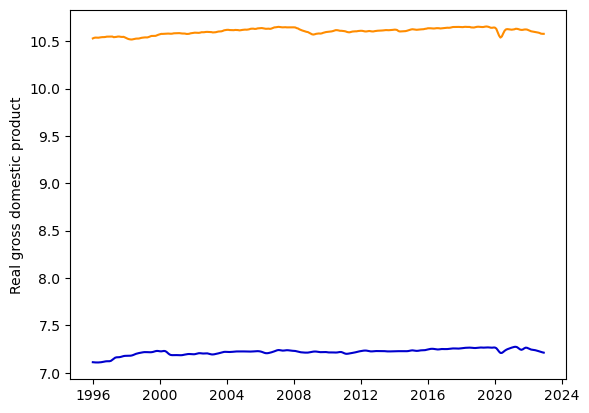

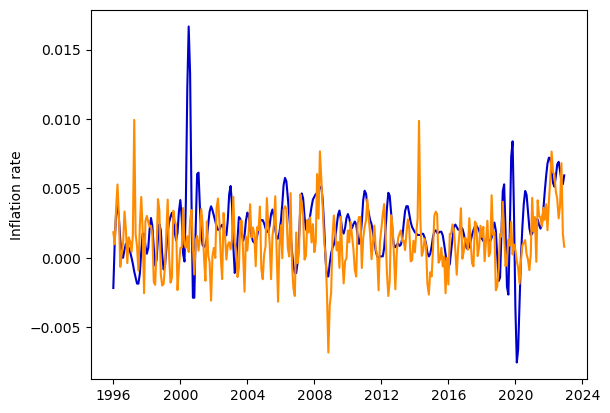

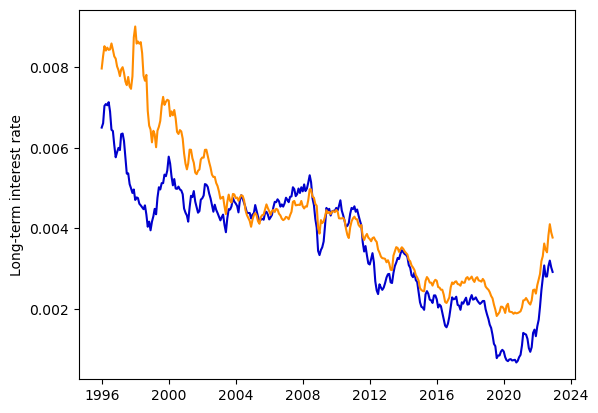

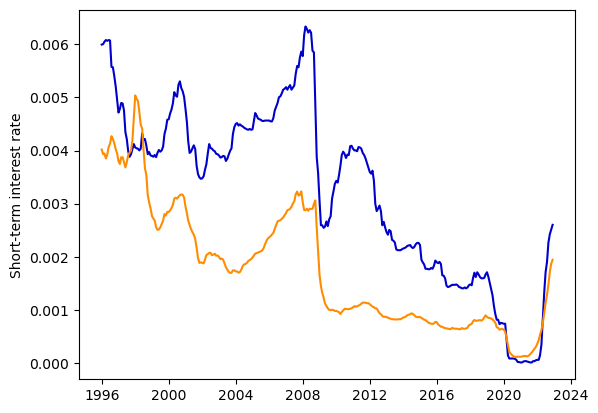

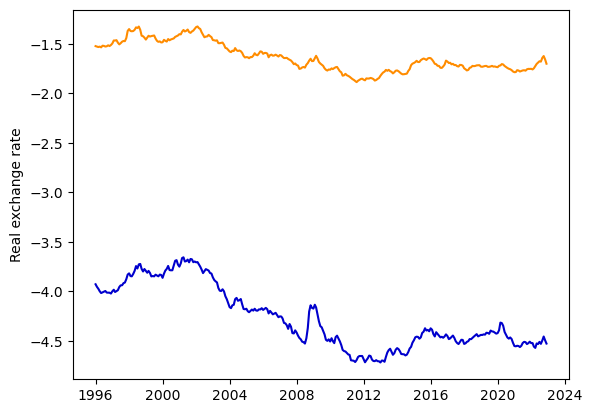

In [449]:
# Define the country
country = 'Australia'

# Define the x_it and x_star for a country
x_it = df[country].T
x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)

# Plot x_it and x_star for every variable
for i in range(len(variable_list)):
    sns.lineplot(x_it[variable_list[i]],c='mediumblue')
    sns.lineplot(x_star[variable_list[i]],c='darkorange')
    plt.ylabel(ext_variable_list[i])
    plt.show()

# Determine the lag order

In [409]:
lag_dict = {}

for country in country_list:#
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"

    max_lags = 5
    
    min_bic = 0

    for lag_x_it in range(1,max_lags+1):
        for lag_x_star in range(1,max_lags+1):
            
            df_country = pd.concat([x_star])
            df_country.columns += "_L0"
    
            for lag in range(1,lag_x_it+1):
                lagged_x_it = x_it.shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
            for lag in range(1,lag_x_star+1):
                lagged_x_star = x_star.shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
            model = VAR(endog = x_it.iloc[max_lags:], exog = df_country.iloc[max_lags:])
            results = model.fit(maxlags=0,trend='ct')
            
            results_bic = -2 * results.llf / 5 + 5 * (lag_x_it+lag_x_star) * np.log(324)
            
            if (results_bic < min_bic):
                min_bic = results_bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    print("For",country)
    print("The lag order by BIC is ",best_lag_bic)
    lag_dict[country] = best_lag_bic
    print("")

For Australia
The lag order by BIC is  (4, 1)

For Brazil
The lag order by BIC is  (4, 1)

For Canada
The lag order by BIC is  (4, 4)

For France
The lag order by BIC is  (4, 4)

For Germany
The lag order by BIC is  (4, 4)

For Italy
The lag order by BIC is  (4, 4)

For Japan
The lag order by BIC is  (4, 1)

For Korea
The lag order by BIC is  (4, 1)

For New Zealand
The lag order by BIC is  (4, 4)

For South Africa
The lag order by BIC is  (3, 3)

For Spain
The lag order by BIC is  (4, 4)

For United Kingdom
The lag order by BIC is  (4, 4)

For United States
The lag order by BIC is  (4, 4)



In [410]:
lag_dict

{'Australia': (4, 1),
 'Brazil': (4, 1),
 'Canada': (4, 4),
 'France': (4, 4),
 'Germany': (4, 4),
 'Italy': (4, 4),
 'Japan': (4, 1),
 'Korea': (4, 1),
 'New Zealand': (4, 4),
 'South Africa': (3, 3),
 'Spain': (4, 4),
 'United Kingdom': (4, 4),
 'United States': (4, 4)}

# Test order of integration

In [459]:
df_test_lag0 = pd.DataFrame(index=variable_list)
adf_test_lag0 = pd.DataFrame(index=variable_list)

df_test_lag1 = pd.DataFrame(index=variable_list)
adf_test_lag1 = pd.DataFrame(index=variable_list)

df_test_lag2 = pd.DataFrame(index=variable_list)
adf_test_lag2 = pd.DataFrame(index=variable_list)

for country in country_list:
    for variable in variable_list:
        non_dif = df[country].loc[variable]
        first_dif = np.diff(non_dif)
        second_dif = np.diff(first_dif)
        
        df_test_lag0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif)[0],4)
        adf_test_lag0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC')[0],4)
        df_test_lag1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif)[0],4)
        adf_test_lag1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC')[0],4)
        df_test_lag2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif)[0],4)
        adf_test_lag2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC')[0],4)

In [466]:
adf_test_lag0

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-3.9972,0.1723,-3.1870,-2.0843,-0.7615,0.0668,-1.7600,-1.1241,-1.8749,0.9149,-1.0482,-0.1447,-1.8195
inf_rate,-2.3015,-8.8342,-3.4649,-2.0514,-0.9618,-0.7950,-2.6179,-3.8774,-3.6904,-4.5406,-3.2829,-1.3863,-3.9688
long_int,-2.1007,-2.0935,-1.8570,-1.8167,-3.5143,-3.0291,-1.9575,-1.6703,-2.8168,-2.3803,-1.9494,-1.5656,-2.2266
short_int,-2.1967,-1.9729,-2.3774,-1.8776,-1.9043,-2.5281,-1.9795,-2.3196,-1.6292,-2.4652,-2.9912,-1.6485,-2.5937
exch_rate,-1.0666,-1.5518,-1.3361,-1.3967,-1.3184,-1.3118,-2.2597,-1.5331,-0.9751,-2.5683,-1.1651,-2.2472,0.4725


In [467]:
adf_test_lag1

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-4.5072,-8.9340,-8.6842,-5.5158,-3.5344,-5.7265,-4.8675,-5.9161,-4.9314,-3.7827,-4.5496,-5.5550,-10.5397
inf_rate,-8.2493,-7.3649,-12.8896,-10.2663,-14.9156,-3.9910,-12.9755,-11.7840,-6.7401,-7.2351,-6.2073,-7.2508,-11.3618
long_int,-13.1801,-15.1271,-8.5368,-8.3871,-13.4161,-11.3118,-7.6055,-11.9097,-4.8321,-8.3474,-12.2341,-6.3679,-8.3227
short_int,-6.3407,-6.3658,-6.8338,-7.9051,-5.8285,-6.0444,-6.6043,-4.6502,-5.4796,-8.9685,-7.9843,-6.3956,-2.9782
exch_rate,-11.8071,-11.6389,-13.2196,-13.4202,-13.6084,-13.4602,-13.5481,-6.1146,-13.2125,-11.8629,-13.3885,-14.8400,-10.1262


In [468]:
adf_test_lag2

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-9.6217,-6.9812,-9.8233,-7.3823,-8.7225,-6.7176,-9.0841,-7.0581,-8.5873,-9.0547,-7.9942,-7.0979,-9.3331
inf_rate,-9.4404,-9.3960,-11.0366,-10.5338,-9.7539,-9.1345,-10.2828,-10.2703,-7.5533,-10.9929,-7.7876,-11.2528,-9.7067
long_int,-10.0621,-8.4422,-10.0782,-9.6748,-7.0275,-6.9997,-8.3788,-9.6240,-10.1189,-9.8091,-10.4261,-6.1369,-10.7583
short_int,-6.9016,-9.3111,-10.2895,-8.5028,-8.6447,-8.0025,-9.1744,-8.2630,-10.3071,-9.2988,-10.5679,-9.4654,-10.5596
exch_rate,-8.8329,-8.9573,-9.8931,-8.1608,-8.0535,-8.4854,-8.4022,-11.5812,-7.4537,-9.9645,-8.5781,-7.7073,-9.7561


# Fitting the model

In [363]:
lag_x_it = 4
lag_x_star = 4


# Define a dataframe (dictionary) for the parameter estimates and the R_squared
df_estimates = {}
df_Rsquared = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    df_country = pd.concat([x_star])
    df_country.columns += "_L0"
    
    for lag in range(1,lag_x_it+1):
        lagged_x_it = x_it.shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
    for lag in range(1,lag_x_star+1):
        lagged_x_star = x_star.shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    model = VAR(endog = x_it.iloc[max_lags:], exog = df_country.iloc[max_lags:])
    results = model.fit(maxlags=0,trend='ct')
    
    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [366]:
df_estimates['Japan']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_star_L3,inf_rate_x_star_L3,long_int_x_star_L3,short_int_x_star_L3,exch_rate_x_star_L3,GDP_x_star_L4,inf_rate_x_star_L4,long_int_x_star_L4,short_int_x_star_L4,exch_rate_x_star_L4
GDP_x_it,0.493210,1.123912e-05,0.879218,0.691046,-0.033598,-1.508632,0.002421,3.381542,2.430216,0.137129,...,-3.142874,-1.105161,-1.162694,2.988726,0.033393,0.988325,-0.005066,0.407601,-1.121796,-0.002039
inf_rate_x_it,-0.375694,-1.404832e-05,-0.139969,-0.013404,0.008563,1.921867,-0.012748,-0.372355,-0.424372,-0.025658,...,0.976678,0.468323,1.184338,-1.566987,-0.024488,-0.353493,-0.045073,-0.333744,0.634950,0.002494
long_int_x_it,0.048988,7.288482e-07,0.004955,0.026725,0.326198,0.388319,0.005577,-0.019106,-0.020977,1.161624,...,0.019230,0.004705,-0.262468,-0.070621,0.003525,-0.010113,-0.000679,0.149309,-0.093935,0.000092
short_int_x_it,-0.001379,-1.095063e-07,0.001245,0.001735,0.007477,0.003972,-0.000200,0.000100,0.000889,-0.005836,...,-0.002018,-0.000406,-0.002343,0.018516,0.000155,0.000525,0.000095,0.003444,-0.001899,0.000012
exch_rate_x_it,1.843795,8.969579e-06,1.454946,2.150852,13.712801,12.370320,0.510723,1.505640,1.492286,1.740868,...,-5.776268,-1.513036,-8.455080,-8.323928,0.115780,1.642340,-0.377187,10.474931,21.923078,-0.039935


In [367]:
# Example of the VARX estimates of Australia
df_estimates['France']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_star_L3,inf_rate_x_star_L3,long_int_x_star_L3,short_int_x_star_L3,exch_rate_x_star_L3,GDP_x_star_L4,inf_rate_x_star_L4,long_int_x_star_L4,short_int_x_star_L4,exch_rate_x_star_L4
GDP_x_it,0.128219,-1.310613e-06,1.343181,0.338912,1.621433,-0.296344,-0.003800,2.953120,2.379369,0.791845,...,-3.716054,-1.025905,-0.144467,-6.783690,-0.022711,1.020930,0.047354,-0.607074,5.129568,0.038815
inf_rate_x_it,-0.126376,8.171633e-06,-0.123932,0.886738,-1.636705,-0.142479,0.003488,-0.044105,-0.460275,-0.732365,...,0.623376,0.154659,0.336605,5.920540,0.008526,-0.111542,-0.012905,0.214999,-4.336122,-0.040191
long_int_x_it,0.000849,-5.450918e-07,0.008201,0.012766,0.529577,0.321437,-0.000728,-0.001551,0.003227,1.061148,...,-0.017503,0.001583,-0.090086,-0.332141,0.000542,0.003902,-0.002177,0.005924,0.211885,0.000994
short_int_x_it,0.001254,-1.524693e-07,-0.000410,-0.001896,0.022491,0.926736,-0.000119,-0.000633,0.000552,-0.036221,...,-0.001390,0.000729,0.004906,-0.181778,0.000390,0.000104,0.000835,-0.007289,0.141405,-0.000239
exch_rate_x_it,0.235362,-5.936139e-06,0.714064,0.917672,-1.878915,8.019215,1.271270,-0.187648,0.182657,0.144700,...,-1.279478,-0.379366,-1.838734,-8.224590,-0.122592,-0.091461,0.023684,-2.302398,5.442667,0.119758


In [49]:
# Example of the VARX estimates of New Zealand
df_estimates['New Zealand']

,const,trend,L1.GDP_x_it,L1.inf_rate_x_it,L1.long_int_x_it,L1.short_int_x_it,L1.exch_rate_x_it,L1.GDP_x_star,L1.inf_rate_x_star,L1.long_int_x_star,...,L13.GDP_x_it,L13.inf_rate_x_it,L13.long_int_x_it,L13.short_int_x_it,L13.exch_rate_x_it,L13.GDP_x_star,L13.inf_rate_x_star,L13.long_int_x_star,L13.short_int_x_star,L13.exch_rate_x_star
GDP_x_it,-0.000250,-1.080721e-06,3.657746,0.277555,0.403396,0.451663,0.004362,-0.515940,-0.511272,-0.065867,...,-0.226700,0.396456,0.049849,-0.109508,-0.007467,0.650201,-0.036806,0.243232,-1.537935,0.007199
inf_rate_x_it,0.033510,-2.449850e-07,0.013057,2.466126,-0.130619,0.237647,-0.001330,-0.013645,0.020223,0.241383,...,0.062441,0.130884,-0.291541,-0.061809,0.000557,-0.026843,-0.003678,0.047948,0.474311,-0.001575
long_int_x_it,-0.004444,-2.314541e-06,0.040109,0.078814,1.095611,-0.100886,-0.000511,-0.068513,-0.048857,0.059298,...,0.023706,-0.042628,-0.223731,0.071561,0.001772,-0.034687,0.010122,0.046352,0.373416,-0.001549
short_int_x_it,-0.005596,-2.706629e-06,-0.014196,-0.008333,0.058501,1.337558,-0.001293,0.042061,0.044403,-0.057533,...,0.017471,0.002518,0.028354,0.158065,0.000567,-0.038877,-0.003060,-0.082509,-0.041192,-0.001120
exch_rate_x_it,-1.664579,-3.665574e-04,-2.384298,16.789835,12.430471,-27.934580,0.849113,1.036244,1.433090,-16.266786,...,-5.159289,-0.898427,-5.616974,3.195497,-0.114643,10.753315,-0.997102,-11.090383,31.297819,0.331874


In [14]:
# The matrix of R^2 values
df_Rsquared

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,0.996420,0.999823,0.983727,0.978516,0.975789,0.998927,0.993441,0.998754,0.996100,0.999277,0.990944,0.991077,0.985965
inf_rate,0.900378,0.482354,0.237066,0.153338,0.106525,0.311771,0.267246,0.322291,0.903067,0.381685,0.265264,0.300832,0.419196
long_int,0.989153,0.990304,0.993433,0.994413,0.985498,0.982796,0.987872,0.989336,0.989934,0.991537,0.983807,0.964443,0.982094
short_int,0.995529,0.957121,0.993434,0.996983,0.996938,0.997582,0.989441,0.991027,0.995684,0.988694,0.997408,0.996697,0.992848
exch_rate,0.993686,0.985555,0.994810,0.987615,0.987536,0.989952,0.965695,0.984525,0.993207,0.961612,0.991658,0.978264,0.999729
